# Attention De NMT hasta Transformers

## Intro

Attention es uno de los mecanismos que mas ha aumentado e impactado en la precision de los modelos de lenguaje natural (y otras areas luego) de los ultimos tiempos. Situemosnos en el tiempo, era 2014 y necesitabamos hacer traduccion de texto por redes neuronales (NMT por sus siglas en ingles). En ese tiempo lo mejor que se conocia era el modelo un modelo llamado `seq2seq` que era de tipo `encoder-decoder`

<img src="https://drive.google.com/uc?export=view&id=1FKfaArN1rsLjzVWaJGpMLEcxEshSLXd6" alt="drawing" width="600"/>


Pero tenia problemas. 
1) En un sentido este modelo era como leer toda una oracion, recordarla de memoria, y luego traducirla de un bloque. Naturalmente el humano no funciona asi, sino que la ve de a partes y quiere volver a ver cada tanto, sino se olvida cuan mas largo es el texto. Esto se refleja en la grafica siguiente:


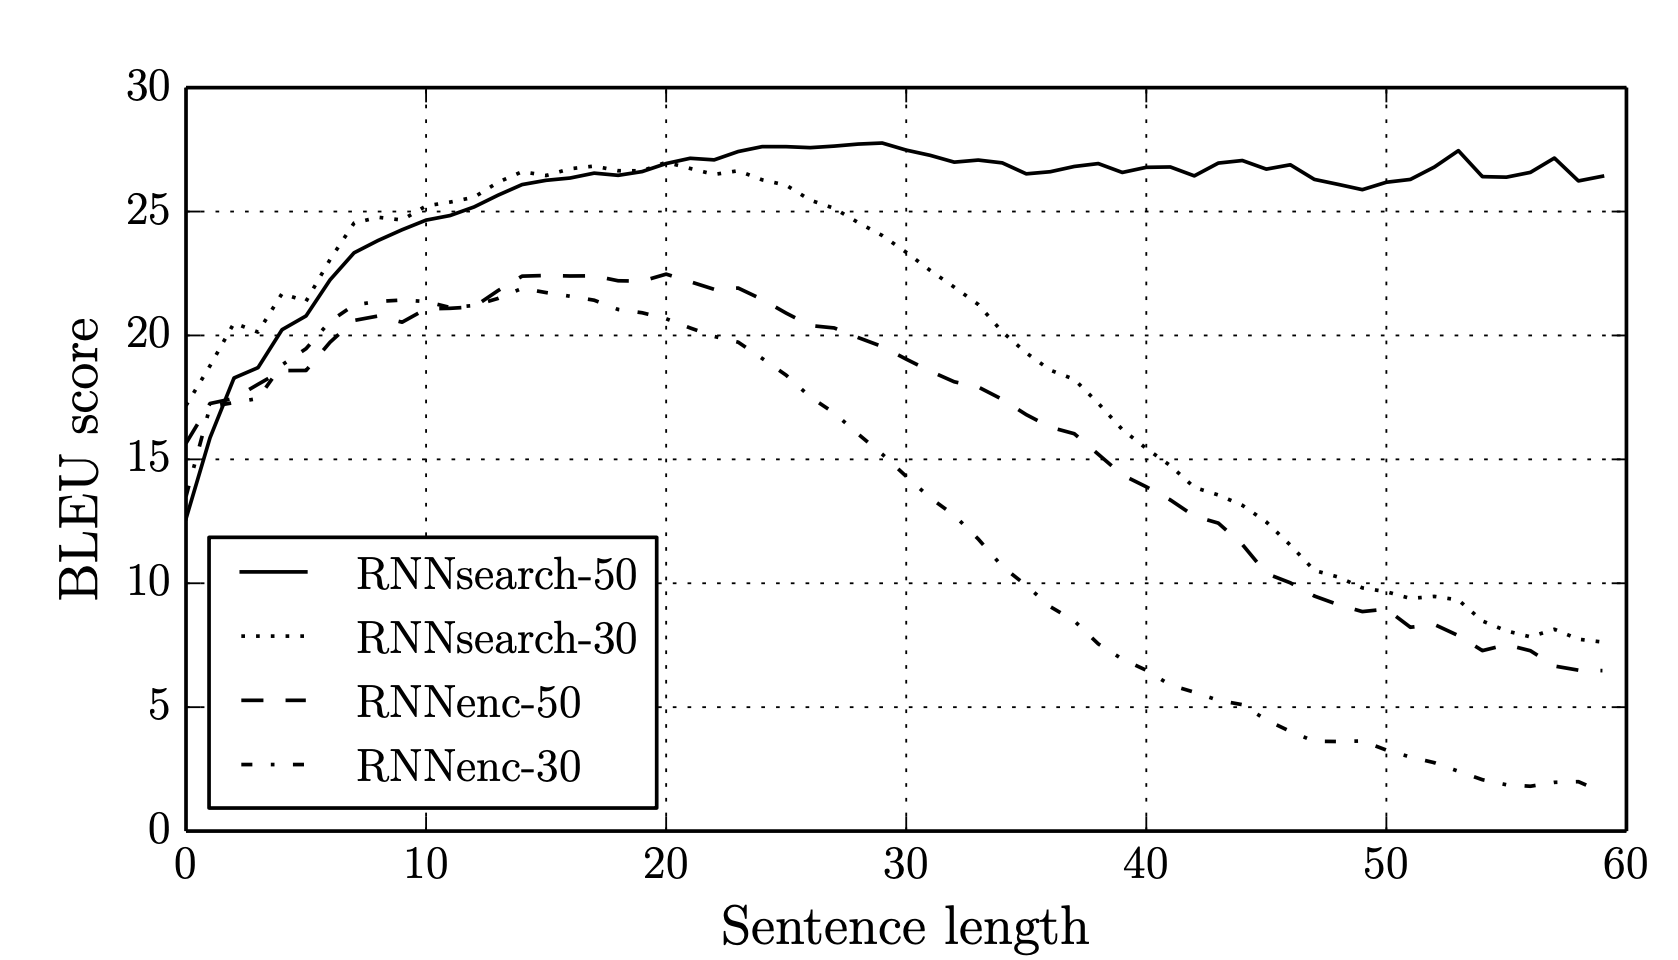

2. El segundo punto es que hay secciones del texto que son mas relevantes en diferentes partes. Veamos dos ejemplos, uno con texto y uno con imagenes:

<img src="https://drive.google.com/uc?export=view&id=1j23kcfu_c3wINU6DUvxzMYNmp4alhHc9" alt="drawing" width="350"/>


<img src="https://drive.google.com/uc?export=view&id=1iEU7Cph2D2PCXp3YEHj30-EndhHAeB5T" alt="drawing" width="450"/>

(image and example [source](https://lilianweng.github.io/posts/2018-06-24-attention/)).

En ambos casos depende el contexto que parte es mas importante. En el caso del texto Apple va a ser mas fuertemente relacionado a `coding` y `computer` en el primer ejemplo, donde el contexto da a computacion. Mientras que en la segunda no.

En el caso del perro Shibu, con los pixeles rojos es natural pensar que lo amarillo va a ser relevante, pero que el poncho no.

Con todo esto los autores proponen el primer mecanismo de Attention, que llamaron Alignment attention.

## Alineando targets

Ya se que queremos ir al codigo, pero primero veamos que vamos a implementar, la idea final es la siguiente:

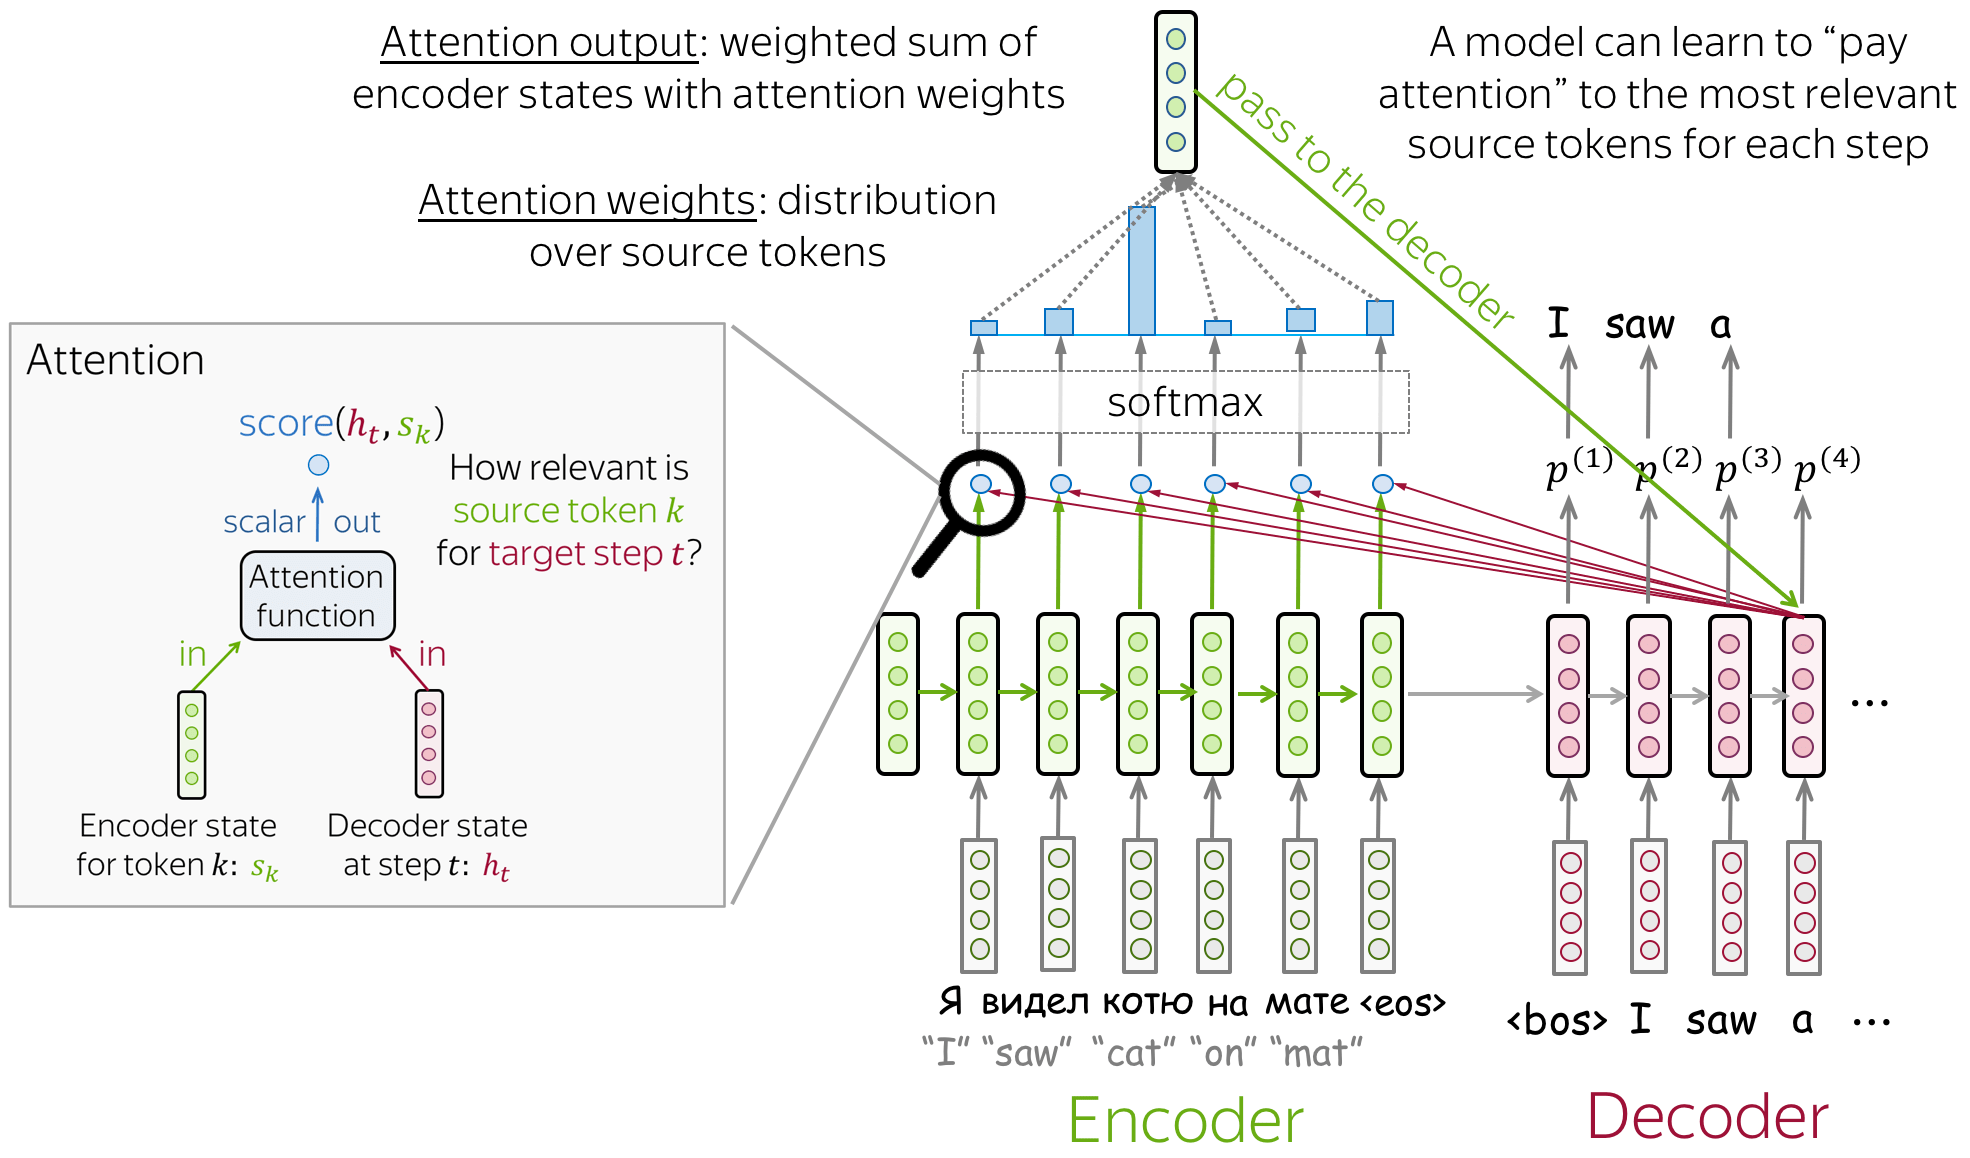

Source: https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#attention_intro

La clave es que para **cada** palabra input y **cada** palabra output se calcula un alignment de que tan relacionadas estas:

$$
a_{ij} = f(h_i, s_{j})
$$

La clave es que esa `f` puede ser cualquier cosa. En el paper usaron el producto interno, o sea:

$$
a_{i,j} = h_i^T*s_j
$$

Y ese numerito va a decir que tan relacionadas estan en el dataset. Entonces ahora para un dado estado interno `h_j` tenemos un vector de numeros de que tan relacionado estan con esa palabra `c_k`, una por cada palabra del decoder. Y que hacemos siempre al tener un vector de probabilidades? Tomamos softmax

$$
z_j = softmax_k(c_{j,k})
$$

O sea ahora al final tenemos un super vector de contexto que tiene informacion no solo del encoder, sino que tambien del decoder y que tan importante es. Eso es attention! En el paper le pasan ese vector a todas las units del decoder y descubren que ahora el modelo recuerda mejor, es como que cada tanto puede ir y ver al pasado para traducir mejor.


<img src="https://drive.google.com/uc?export=view&id=1fB5KObXcKo5x35xlIDIcjHTq1q75ejIB" alt="drawing" width="600"/>

## Al codigo!

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import gensim
from nltk.data import find
import nltk

nltk.download("word2vec_sample")

In [ ]:
def softmax(x, axis=0):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x))

Vamos a usar un embedding preentrenado para mostrar SOLO attention y no attention como parte de un modelo, o como parte de un language model.

In [ ]:
def get_word2vec_embedding(words):
    """
    Function that takes in a list of words and returns a list of their embeddings,
    based on a pretrained word2vec encoder.
    """
    word2vec_sample = str(find("models/word2vec_sample/pruned.word2vec.txt"))
    model = gensim.models.KeyedVectors.load_word2vec_format(
        word2vec_sample, binary=False
    )

    output = []
    words_pass = []
    for word in words:
        try:
            output.append(np.array(model.word_vec(word)))
            words_pass.append(word)
        except:
            pass

    embeddings = np.array(output)
    del model  # free up space again
    return embeddings, words_pass


### Dot Product attention

Lo primero que deberiamos poder hacer, es reimplementar el attention del paper! Hagamoslo, es simplemente tomar producto interno y una softmax!

In [ ]:
def dot_product_attention(hidden_states, previous_state):

    # [T,d]*[d,N] -> [T,N]
    scores = np.matmul(previous_state, hidden_states.T)
    w_n = softmax(scores)

    # [T,N]*[N,d] -> [T,d]
    c_t = np.matmul(w_n, hidden_states)

    return w_n, c_t

Para remarcar, hicimos que la funcion de arriba devuelva el vector de contexto y los weights del attention para ver un plot lindo de que esta haciendo, para eso vamos a usar la siguiente helper function que toma los weights y hace un heatmap contra las palabras que uses

In [ ]:
def plot_attention_weight_matrix(weight_matrix, x_ticks, y_ticks):
    """Function that takes in a weight matrix and plots it with custom axis ticks"""
    plt.figure(figsize=(15, 7))
    ax = sns.heatmap(weight_matrix, cmap="Blues")
    plt.xticks(np.arange(weight_matrix.shape[1]) + 0.5, x_ticks)
    plt.yticks(np.arange(weight_matrix.shape[0]) + 0.5, y_ticks)
    plt.title("Attention matrix")
    plt.xlabel("Attention score")
    plt.show()

Probemoslo las siguientes palabras! Si todo va bien deberia detectar que la parte de realeza se relaciona mas entre si que la parte de comida.

In [ ]:
words = ["king", "queen", "royalty", "food", "apple", "pear", "computers"]
word_embeddings, words = get_word2vec_embedding(words)
weights, _ = dot_product_attention(word_embeddings, word_embeddings)
plot_attention_weight_matrix(weights, words, words)

Effectively!! we see a nice cluster around royalty and another on food, finally computers are alone.

### Self Attention

Attention cambio todo el paradigma del estudio de NLP, y explotaron los usos, teniendo muchos tipos de attention. El mas importante se podria decir es el llamado `Multi-Headed Attention` porque es el propuesto en la arquitectura del Transformer

<img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" width="40%" />

Para entender Multi Headed attention primero tenemos que dominar self attention. En Self attention, que tambien se llama Query, Key, Value attention; la idea es similar a una base de datos.  O sea, nosotros vamos a tener un Key Value pair y con una query primero vamos a calcular que tan relacionado esta la query con la Key, y luego ponderamos los values por eso.


Se podria decir que una base de datos real es como un modelo de atencion KQV tal que la relacion de Q con K es siempre 0 excepto 1 valor donde es 1.

Todo mecanismo de atencion es como este sistema donde la query es lo que quiero, la relacion entre Q y K es los scores de atencion y el value ponderado es el vector de contexto. Porque es importante? Porque en el Transformer vamos a formar matrices WQ, WK, WV que van a ser aprendibles y asi el Transformer va a saber a que prestar atencion.

El segundo punto clave de self-attention es que para cada palabra va a tomarse en cuenta TODA el texto para calcular la atencion. Ahora al codigo, primero un metodo helper que dada una oracion obtiene el embedding

In [ ]:
def embed_sentence(sentence):
    # Embed a sentence using word2vec; for example use cases only.
    sentence = re.sub(r"[^\w\s]", "", sentence)
    words = sentence.split()
    word_vector_sequence, words = get_word2vec_embedding(words)
    return np.expand_dims(word_vector_sequence, axis=0), words


In [ ]:
embed_sentence("I've had a lot of fun")

Ahora lo realmente clave, dada una secuencia X de textos embebidos, hay que calcular los vectores q, k y v:

In [ ]:
def seq_to_kqv(output_size, X):
    # X [sentences, seq_length, embedding_dim]
    q_layer = np.random.rand(output_size, X.shape[1])
    k_layer = np.random.rand(output_size, X.shape[1])
    v_layer = np.random.rand(output_size, X.shape[1])

    Q = np.matmul(q_layer, X)
    K = np.matmul(k_layer, X)
    V = np.matmul(v_layer, X)
    # Aca estamos simplificando a que trabajariamos de a batches de 1 oracion, sino hay que hacer un poco mas de trabajo
    return Q, K, V

Ahora que tenemos las matrices Q, K y V para una dada secuencia de oraciones X, viene el momento de calcular la self-attention. En el paper de "Attention is all you need" sugieren:

$\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V$

In [ ]:
def scaled_dot_product_attention(query, key, value):
    d_k = key.shape[-1]
    logits = np.matmul(query, np.swapaxes(key, -2, -1))
    scaled_logits = logits / np.sqrt(d_k)
    attention_weights = softmax(scaled_logits, axis=-1)
    value = np.matmul(attention_weights, value)
    return value, attention_weights

Naturalmente esto luego lo podemos agregar facilmente en un modelo en Keras o PyTorch, pero aca estamos ganando intuicion del mecanismo. Probemoslo de nuevo!!

In [ ]:
sentence = "I drink coke, but eat steak"
word_embeddings, words = embed_sentence(sentence)
word_embeddings.shape

In [ ]:
Q = K = V = word_embeddings   # Para no entrenar

# calculate weights and plot
values, attention_weights = scaled_dot_product_attention(Q, K, V)
words = re.sub(r"[^\w\s]", "", sentence).split()
plot_attention_weight_matrix(attention_weights[0], words, words)

Notemos que fue un exito, eat y steak quedan relacionados; como a su vez drink coke. Pareceria que no ganamos nada en relacion a performance con dot product attention pero hay un detalle clave: **self-attention es paralelizable en GPU mientras que el dot product attention de seq2seq no**. O sea hay ordenes de magnitud de velocidad de entrenamiento.

## Multi headed Attention

Ahora estamos listos para el modelo de attention mas complejo, y el usado por los Transformers. La idea es "robada" de las CNNs y es hacer scaled self attention muchas veces, porque segun los autores (TODOS premios Turing) hacerlo solo una vez "promedia" todo lo que atenttion podria reconocer. O sea en diagramas es:


<img src="https://drive.google.com/uc?export=view&id=1q0Oq6IVEkkMfVSpY4LkHBP866mcoIFsh" alt="drawing" width="1000"/>

Donde escalamos el output_dim de las matrices de attention (o filtros si mantenemos la nomenclatura de CNN) como `embedding_size/ N_heads)`.

In [ ]:
def mha(num_heads, d_m, name=None, X=None, Q=None, K=None, V=None, mask=None, return_weights=False):
            # project all data to Q, K, V
#         Q, K, V = seq_to_kqv(d_m, X)

        # get the batch size, sequence length and embedding size
        B, T, d_m = K.shape

        # calculate heads embedding size (d_m/N)
        head_size = d_m // num_heads

        # B,T,d_m -> B, T, N, dm//N -> B, N, T, dm//N
        q_heads = Q.reshape(B, -1, num_heads, head_size).swapaxes(1, 2)
        k_heads = K.reshape(B, -1, num_heads, head_size).swapaxes(1, 2)
        v_heads = V.reshape(B, -1, num_heads, head_size).swapaxes(1, 2)

        attention, attention_weights = scaled_dot_product_attention(
            q_heads, k_heads, v_heads
        )

        # (B, nh, T, hs) -> (B, T, nh, hs) -> (B, T, d_m) - re-assemble all head outputs
        attention = attention.swapaxes(1, 2).reshape(B, -1, d_m).squeeze()
        X_new = np.dot(attention, np.random.rand(attention.shape[-1])).squeeze()
        if return_weights:
            return X_new, attention_weights
        else:
            return X_new

In [ ]:
sentence = "I drink coke, but eat steak"
word_embeddings, words = embed_sentence(sentence)
word_embeddings.shape
Q = K = V = word_embeddings


In [ ]:

# calculate weights and plot
values, attention_weights = mha(num_heads=3, d_m=300, Q=Q, K=K, V=V, return_weights=True)
words = re.sub(r"[^\w\s]", "", sentence).split()


In [ ]:
values.shape, attention_weights.shape

Notemos que en efecto ahora no tenemos un attention matrix de 6x6 (o sea 1 self attention) sino 3, porque especifique eso como argumento. Esto es un hiperparametro clave a la hora de tunear Transformers.

Ahora podemos hacer 3 plots, que los invito a hacer, donde jugamos con ver que ve cada uno

In [ ]:
plot_attention_weight_matrix(attention_weights.squeeze()[0], words, words)